### Import packages

In [1]:
# Import packages
print("---------IMPORTING PACKAGES---------")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import random
import csv
import time
import keras

from sklearn.utils import shuffle
from matplotlib import image
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Nadam, Adamax, SGD

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
random.seed(432)


---------IMPORTING PACKAGES---------


### Define the changeable parameters

In [2]:
#########################################################
################### FIXED VARIABLES #####################
#########################################################
input_folder = "/kaggle/input/"
#input_folder_undersampled = input_folder+"eurosat-undersampled"
output_folder = "/kaggle/working/"
verbose = 0 # 0-> dont print training info, 1-> print them
n_epochs = 2

# Model parameters
pooling_kernel_size = (2,2)
stride = (1,1)
#########################################################



##############################################################
################### HYPERPARAMETER OPTIONS ###################
##############################################################
# Element [0] is default
batch_size_opts = [128, 256, 64] # How big of a set of data to use for every training epoch
loss_fun_opts = ["categorical_crossentropy",
                 "kl_divergence",
                 "mean_absolute_error",
                 "mean_squared_logarithmic_error"]
act_fun_opts = ["relu", "elu"]
learn_rate_opts = [0.0001, 0.0007, 0.001]

learn_rate = learn_rate_opts[0] # 2g # FIXED FOR NOW

optmzer_opts = [Adam(learning_rate=learn_rate),
                Nadam(learning_rate=learn_rate),
                Adamax(learning_rate=learn_rate),
                SGD(learning_rate=learn_rate)]

# Model Architecture:
n_convolutional_layers_opts = [2, 4, 5, 8]
filter_size_opts = [(2,2), (3,3), (5,5)] # kernel size of the convolutional layer

filter_number_opts = [[16, 32],
                      [16, 16, 32, 32],
                      [16, 32, 32, 32, 64],
                      [16, 16, 32, 32, 64, 64, 128, 128]] # DEPENDS ON NUMBER OF CONVOLUTIONAL LAYERS 
##############################################################



##############################################################
################### HYPERPARAMETER VALUES ####################
##############################################################
batch_size = batch_size_opts[0] # 2e
loss_fun = loss_fun_opts[0] # FIXED FOR NOW
act_fun = act_fun_opts[0] # 2d
optmzer = optmzer_opts[0] # 2f
n_convolutional_layers = "current variable" # 2a
filter_size = filter_size_opts[0] # 2b
filters_number = "current variable"


params = [n_epochs,
          batch_size,
          loss_fun, 
          act_fun,
          learn_rate, 
          optmzer,
          n_convolutional_layers,
          filter_size,
          filters_number
         ]

For the number of filters, it makes sense to increase gradually. So that you could leave as a more fixed variable. 
start with few to get the rough features (line direction) and increase afterwards to pick up on the more abstract details. But don't go too big, else comp complexity spikes up.

### Create a fine to save the results

In [3]:
# Open the excel file where I'll save all the test results (metrics)

# TODO: add computational complexity

with open("./results.csv", "w") as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Create a row with the column names:
    filewriter.writerow(["model_ID",
                         "model_name", 
                         "n_epochs", # params[0]
                         "batch_size", # params[1]
                         "loss_function", # params[2]
                         "activation_fun", # params[3]
                         "learning_rate", # params[4]
                         "optimizer", # params[5]
                         "num_conv_layers", # params[6]
                         "kernel_size", # params[8]
                         "filter_number", # params[9]
                         "train_time_per_epoch",
                         "num_epochs_run", # epoch where it stopped automatically
                         "test_loss",
                         "test_accuracy",
                         "test_auc",
                         "wa_precision", # wa = weighted average
                         "wa_recall",
                         "wa_f1_score",
                         "wrong_preds",
                         "total_preds",
                         "num_train", # number of images in the training set
                         "num_val", # number of images in the validation set
                         "num_test" # number of images in the test set  
                        ])

### Define functions

In [4]:
# https://stackoverflow.com/questions/39280813/visualization-of-convolutional-layer-in-keras-model
# Merdan Memtimin https://stackoverflow.com/users/6565409/merdan-memtimin
def plot_conv_weights(model, layer_name):
    W = model.get_layer(name=layer_name).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))
            
            
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names, skiprows=1)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names, skiprows=1)
    test_df = pd.read_csv(data_folder + test_file, names = column_names, skiprows=1)
    
    return training_df, validation_df, test_df


def flatten(d):
    v = [[i] if not isinstance(i, list) else flatten(i) for i in d]
    return [i for b in v for i in b]


def precision(confusion_matrix):
    """Given a confusion matrix, calculates and returns precision for all classes"""
    precision_list = []
    for i in range(confusion_matrix.shape[1]):
        current_col = confusion_matrix[:,[i]]
        current_el = confusion_matrix[i,[i]]
        current_precision = (float(current_el/sum(current_col)[0]))
        current_precision = round(current_precision, 4)
        precision_list.append(current_precision)
    return precision_list

def recall(confusion_matrix):
    """Given a confusion matrix, calculates and returns recall for all classes"""
    recall_list = []
    for i in range(confusion_matrix.shape[0]):
        current_row = confusion_matrix[i,:]
        current_el = confusion_matrix[i,i]
        current_recall = round(current_el/sum(current_row), 4)
        recall_list.append(current_recall)
    return(recall_list)

def f1_score(precision, recall):
    """Given a list of precision and recall values for a certain matrix,
    returns f-1 values for each class"""
    f1_scores = []
    if len(precision) == len(recall):
        for i in range(len(precision)):
            current_f1 = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
            f1_scores.append(round(current_f1, 4))
    else:
        print("Error. Precision and Recall lists should be of equal lengths.")
    return f1_scores


### Load data

In [5]:
print("---------LOADING DATA---------")
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"
column_names =  ["id", "path", "class_id", "class_name"]

training_df, validation_df, test_df = load_metadata(dataset_folder,
                                                    "train.csv",
                                                    "validation.csv",
                                                    "test.csv",
                                                    column_names)

---------LOADING DATA---------


### Preprocessing

In [6]:
# The data is already normalized so that pixels values range from 0,255. We can rescale pixel value between
# [0,1] by divinding by 255.

rescaling_factor = 1. / 255
# Generate batches of tensor image data by setting up the generators.
# If you want to perform augmentation, add parameters to the training_generatorF
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

# Size of input data is 64x64 pixels
image_width, image_height = (64, 64)

### Build train, val, test sets

In [7]:
print("Building training set.")
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False, # for replicability. Anyways they are already shuffled.
)

print("\nBuilding validation set.")
validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

print("\nBuilding test set")
test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)




class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

class_count = len(class_name_list)



Building training set.
Found 18900 validated image filenames belonging to 10 classes.

Building validation set.
Found 5400 validated image filenames belonging to 10 classes.

Building test set
Found 2700 validated image filenames belonging to 10 classes.


# Ablation Study

In [8]:
print("---------START OF ABLATION EXPERIMENTS---------")

---------START OF ABLATION EXPERIMENTS---------


## Define Functions
### Compile and Fit

Define Time History class to record time taken per epoch.

In [9]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [10]:
def run_model(model, model_name, params):
    """
    Given a model architecture, the function compiles and fits the model.
    
    model: model architecture
    model_name: "str", name used as model description in the output file
    params: an array containing the values for the training parameters, namely:
    [n_epochs, batch_size, loss_fun, act_fun, learn_rate, optmzer]
    """
    # Path to save the model
    model_path = "/kaggle/working/eurosat_rgb_" + model_name + ".h5"
    # Save the weigths of the best model
    checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
    # Reduce learning rate when val_loss stops improving for 5 epochs.
    # reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    # Stop training if a val_loss has stopped improving for 5 epochs.
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=verbose)
    
    time_callback = TimeHistory()
    callback_list = [checkpoint, early_stopping, time_callback] #, reduce_lr]
    
    metrics=['accuracy',
             tf.keras.metrics.AUC(from_logits=True)]
    
    print("---------MODEL COMPILE---------")
    model.compile(loss=params[2],
                  optimizer=params[5],
                  metrics=metrics)

    print("---------MODEL FIT---------")
    
    history = model.fit(
        training_set,
        validation_data=validation_set,
        callbacks=callback_list,
        epochs=params[0],
        verbose=verbose,
    )
    
    times = time_callback.times
    avg_time_epoch = sum(times)/len(times)
    new_params = params
    new_params.append(avg_time_epoch)

    return history, new_params

### Get Evaluation Metrics

In [11]:
def get_eval_metrics(history, model, test_set, params):
    """
    Given a trained model and a test set, the function returns model eval metrics.
    
    
    """
    print("---------MODEL EVALUATE---------")
    
    n_ran_epochs = len(history.history['loss'])
    
    loss, accuracy, auc = model.evaluate(test_set, verbose=verbose)
    
    test_set.reset()
    predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=verbose)
    predicted_class_ids = np.argmax(predicted_probabilities, axis=1)
    report = metrics.classification_report(test_set.labels, predicted_class_ids, output_dict=True)
    wa_prec = report["weighted avg"]["precision"]
    wa_rec = report["weighted avg"]["recall"]
    wa_f1 = report["weighted avg"]["f1-score"]
    cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
    confusion_matrix_df = pd.DataFrame(
        data=cf_matrix, 
        index=class_name_list, 
        columns=class_name_list
    )
    results_df = pd.DataFrame(
        {
            "label": test_set.labels, 
            "prediction": predicted_class_ids, 
            "path": test_set.filepaths
        }
        )

    mistakes = results_df["label"] != results_df["prediction"]
    mistakes_df = results_df[mistakes]
    wrong_preds = len(mistakes_df)
    tot_preds = len(results_df)

    print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))
    
    
    eval_metrics = [n_ran_epochs,
                   loss,
                   accuracy,
                   auc,
                   wa_prec,
                   wa_rec,
                   wa_f1,
                   wrong_preds,
                   tot_preds
        ]
    
    return eval_metrics, cf_matrix, confusion_matrix_df, results_df

### Save plots

In [12]:
def save_plots(history, output_folder, model_name, confusion_matrix_df):
    plt.subplot(1, 2, 1)
    # Loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss - " + model_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Accuracy - " + model_name)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    #plt.show()
    plt.savefig(output_folder + model_name + "_training_curves.png")
    
    # CONFUSION MATRIX IMAGE
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1)
    sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
    plt.ylabel("Label")
    plt.xlabel("Prediction")
    plt.title("Confusion matrix - " + model_name)
    #plt.show()
    plt.savefig(output_folder + model_name + "_confusion.png")

### Save numerical results

In [13]:
def append_results_to_csv(csv_row):
    print("---------SAVE RESULTS---------")
    """Append the results to the csv file
    csv_row: list, contains the information to append to the csv"""
    
    with open("./results.csv", 'a+', newline='') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        # Create a row with the column names:
        filewriter.writerow(csv_row)


# EXPERIMENT 2A.i.i

-------- EXPERIMENT 2A.i.1 ----------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              16385000  
_________________________________________________________________
dropout (Dropout) 

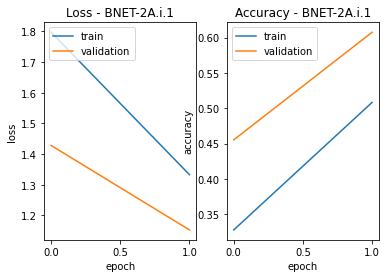

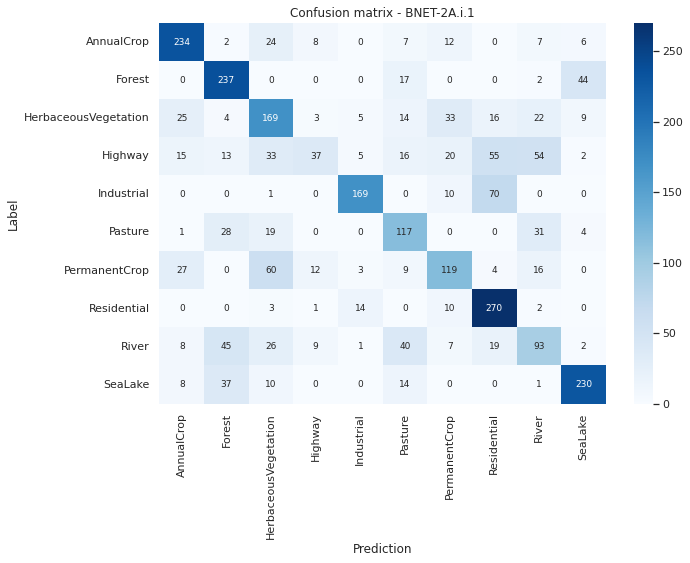

In [14]:
n_layers = 2

params[6] = n_layers
params[8] = filter_number_opts[0]

model_id = "2A.i.1"
model_name = f"BNET-{model_id}"

print(f"-------- EXPERIMENT {model_id} ----------")


model = Sequential()
model.add(Conv2D(input_shape=(64,64,3),filters=32,kernel_size=(3,3),padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=1000, activation=act_fun, kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation="softmax"))

model.summary()


# Model COMPILE and FIT
history, new_params = run_model(model, model_name, params)
params = new_params
# Model EVALUATE
eval_metrics, cf_matrix, confusion_matrix_df, results_df = get_eval_metrics(history, model, test_set, params)

save_plots(history, output_folder, model_name, confusion_matrix_df)

new_row = [model_id,
           model_name,
           params,
           eval_metrics,
           len(training_df), # number of images in the training set
           len(validation_df), # number of images in the validation set
           len(test_df), # number of images in the test set
          ]

new_row = flatten(new_row)

append_results_to_csv(new_row)


In [15]:
n_layers = 4

params[6] = n_layers
params[8] = filter_number_opts[1]

model_id = "2A.i.2"
model_name = f"BNET-{model_id}"

print(f"-------- EXPERIMENT {model_id} ----------")


model = Sequential()
model.add(Conv2D(input_shape=(64,64,3),filters=32,kernel_size=(3,3),padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=250, activation=act_fun, kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation="softmax"))

model.summary()

-------- EXPERIMENT 2A.i.2 ----------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D

In [16]:
n_layers = 5

params[6] = n_layers
params[8] = filter_number_opts[2]

model_id = "2A.i.3"
model_name = f"BNET-{model_id}"

print(f"-------- EXPERIMENT {model_id} ----------")


model = Sequential()
model.add(Conv2D(input_shape=(64,64,3),filters=32,kernel_size=(3,3),padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=200, activation=act_fun, kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation="softmax"))

model.summary()

-------- EXPERIMENT 2A.i.3 ----------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D

In [17]:
n_layers = 8

params[6] = n_layers
params[8] = filter_number_opts[3]

model_id = "2A.i.4"
model_name = f"BNET-{model_id}"

print(f"-------- EXPERIMENT {model_id} ----------")


model = Sequential()
model.add(Conv2D(input_shape=(64,64,3),filters=32,kernel_size=(3,3),padding="same", activation=act_fun))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=act_fun))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=300, activation=act_fun, kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation="softmax"))

model.summary()

-------- EXPERIMENT 2A.i.4 ----------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2